In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [24]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(3)

In [ ]:
PATH = Path('data/road-damage')
list(PATH.iterdir())

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [4]:
trn_j = json.load((PATH/'road-damage.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [ ]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

In [8]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

Each image has a unique ID.

In [ ]:
IMG_PATH = PATH/'images'
list(IMG_PATH.iterdir())[:5]

In [13]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [14]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [15]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [17]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [21]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [24]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [20]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [20]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [21]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [22]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [23]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [26]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [ ]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [27]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [25]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [26]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [ ]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

Now we have a dictionary from image id to a single bounding box - the largest for that image.

In [27]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [28]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [29]:
f_model = resnet34
sz=224
bs=64

From here it's just like Dogs vs Cats!

In [30]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [201]:
x,y=next(iter(md.val_dl))

In [220]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [ ]:
lrf=learn.lr_find(1e-5,100)

When you LR finder graph looks like this, you can ask for more points on each end:

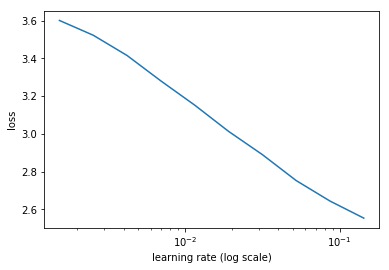

In [36]:
learn.sched.plot()

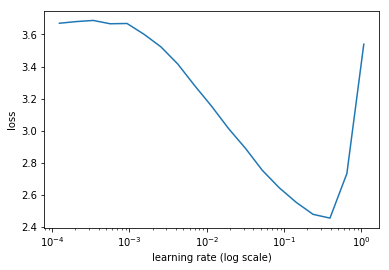

In [35]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [43]:
lr = 2e-2

In [44]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.335532   0.6443     0.804838  



[0.6443001, 0.80483774095773697]

In [45]:
lrs = np.array([lr/1000,lr/100,lr])

In [46]:
learn.freeze_to(-2)

A Jupyter Widget

 84%|████████▍ | 27/32 [00:07<00:01,  3.76it/s, loss=4.99] 


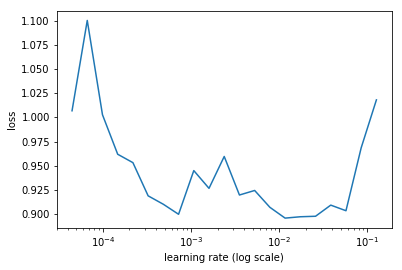

In [39]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [47]:
learn.fit(lrs/5, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.780925   0.575539   0.821064  



[0.57553864, 0.82106370478868484]

In [48]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [49]:
learn.fit(lrs/5, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.609306   0.570568   0.821514  
    1      0.462856   0.574303   0.8128                    



[0.57430345, 0.81280048191547394]

In [51]:
learn.save('clas_one')

In [221]:
learn.load('clas_one')

In [222]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()